<a href="https://colab.research.google.com/github/Penelopeeirini/Master-Thesis/blob/main/Deeptrack2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deeptrack
import deeptrack as dt
import numpy as np

In [4]:
import matplotlib.pyplot as plt

In [6]:
IMAGE_SIZE=51
particle = dt.PointParticle(
position=lambda:np.random.uniform(
IMAGE_SIZE / 2 - 5,
IMAGE_SIZE / 2 + 5,
size=2,
),
)

In [8]:
optics = dt.Fluorescence(
output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),)

TRAIN EASIER THE NEURAL NETWORK

In [9]:
normalization = dt.NormalizeMinMax(0, 1)

SIMULATION PIPELINE

In [12]:
data_simulation = optics(particle) >> normalization
data = np.zeros((1000, IMAGE_SIZE, IMAGE_SIZE, 1))
ground_truth = np.zeros((1000, 2))

In [13]:
for i in range(1000):
  data_simulation.update()
  data[i] = data_simulation()
  ground_truth[i] = particle.position()


PARTICLE PLOTS


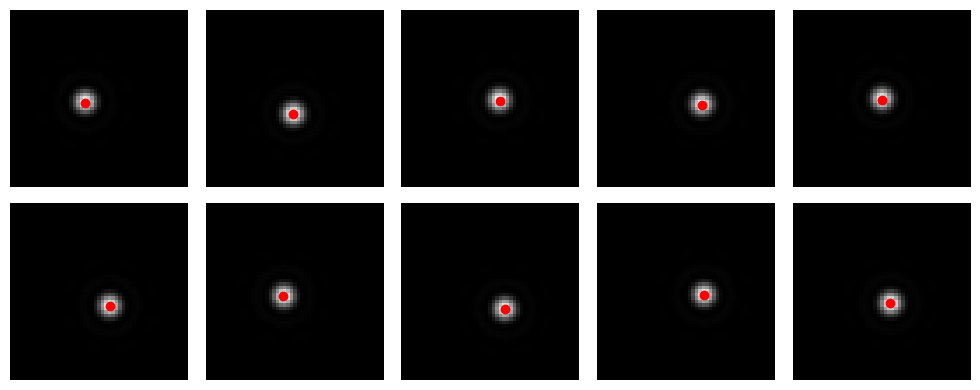

In [16]:
plt.figure(figsize=(10, 4))
for i in range(10):
  plt.subplot(2, 5, i + 1)
  plt.imshow(data[i, ..., 0], cmap="gray")
  plt.scatter(ground_truth[i, 1], ground_truth[i, 0], c="r")
  plt.axis("off")
  plt.tight_layout()
plt.show()